In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as onp
import pandas as pd

import jax.numpy as np
from jax import lax, random, vmap
from jax.config import config; config.update("jax_platform_name", "cpu")

import numpyro.distributions as dist
from numpyro.diagnostics import hpdi
from numpyro.distributions.util import softmax
from numpyro.handlers import sample, seed, substitute, trace
from numpyro.hmc_util import initialize_model
from numpyro.mcmc import mcmc

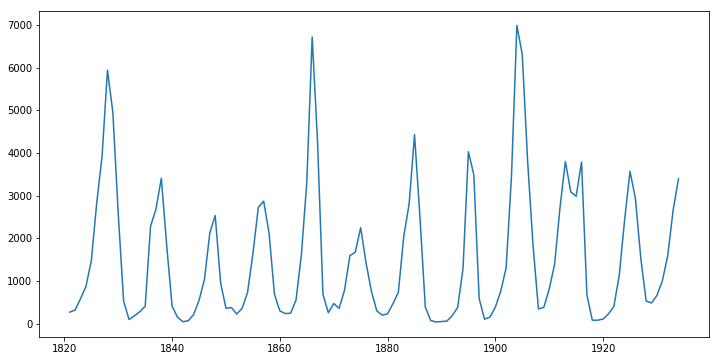

In [2]:
lynx = pd.read_csv("lynx.csv", index_col=0)
data = lynx["value"].values
plt.figure(figsize=(12, 6))
plt.plot(lynx["time"], data);

### Model

$$
\begin{equation}
\text{exp_val}_{t} = \left(\text{level}_{t-1} + \text{coef_trend} * \text{level}_{t-1}^{\text{pow_trend}}\right) * \text{s}_t\\
\sigma_{t} = \sigma * \text{exp_val}_{t}^{\text{powx}} + \text{offset}\\
y_{t} \sim StudentT(\nu, \text{exp_val}_{t}, \sigma_{t})\\
\end{equation}
$$
where `level` and `s` follows the following recursion rules:
$$
\begin{equation}
\text{level}_{t} = \text{level_sm} * \frac{y_{t}}{\text{s}_{t}} + (1 - \text{level_sm}) * \text{level}_{t-1}\\
\text{s}_{t + \text{seasonality}} = \text{s_sm} * \frac{y_{t}}{\text{level}_{t}} + (1 - \text{s_sm}) * \text{s}_{t}\\
\end{equation}
$$

In [3]:
def scan_exp_val(y, level_init, s_init, level_sm, s_sm, coef_trend, pow_trend, seasonality):
    def scan_fn(carry, y_t):
        level, s = carry
        exp_val = (level + coef_trend * level ** pow_trend) * s[0]
        exp_val = np.clip(exp_val, a_min=0)
        level = level_sm * y_t / s[0] + (1 - level_sm) * level
        new_s = s_sm * y_t / level + (1 - s_sm) * s[0]
        s = np.concatenate([s[1:], new_s[None]], axis=0)
        return (level, s), exp_val

    return lax.scan(scan_fn, (level_init, s_init), y)

In [4]:
# Prior info: https://github.com/cbergmeir/Rlgt/blob/master/Rlgt/R/rlgtcontrol.R
def sgt(y, seasonality):
    cauchy_sd = np.max(y) / 150

    nu = sample("nu", dist.Uniform(2, 20))
    powx = sample("powx", dist.Uniform(0, 1))
    sigma = sample("sigma", dist.HalfCauchy(cauchy_sd))
    offset_sigma = sample("offset_sigma", dist.TruncatedCauchy(low=1e-10, loc=1e-10,
                                                               scale=cauchy_sd))

    coef_trend = sample("coef_trend", dist.Cauchy(0, cauchy_sd))
    pow_trend_beta = sample("pow_trend_beta", dist.Beta(1, 1))
    pow_trend = 1.5 * pow_trend_beta - 0.5

    level_sm = sample("level_sm", dist.Beta(1, 2))
    s_sm = sample("s_sm", dist.Uniform(0, 1))
    init_s = sample("init_s", dist.Cauchy(np.zeros(seasonality), 4))
    s_init = softmax(init_s) * seasonality
    level_init = y[0] / s_init[0]
    s_init = np.concatenate([s_init[1:], s_init[:1]], axis=0)

    (last_level, last_s), exp_val = scan_exp_val(
        y[1:], level_init, s_init, level_sm, s_sm, coef_trend, pow_trend, seasonality)
    omega = sigma * exp_val ** powx + offset_sigma
    sample("y", dist.StudentT(nu, exp_val, omega), obs=y[1:])
    return last_level, last_s

In [13]:
# Ref: https://github.com/cbergmeir/Rlgt/blob/master/Rlgt/R/forecast.rlgtfit.R
def sgt_forecast(asample, future, *args, **kwargs):
    pow_trend = 1.5 * asample["pow_trend_beta"] - 0.5
    level, s = substitute(sgt, asample)(*args, **kwargs)
    for t in range(future):
        exp_val = (level + asample["coef_trend"] * level ** pow_trend) * s[0]
        exp_val = np.clip(exp_val, a_min=0)
        omega = asample["sigma"] * exp_val ** asample["powx"] + asample["offset_sigma"]
        yf = sample("yf[{}]".format(t), dist.StudentT(asample["nu"], exp_val, omega))
        yf = np.clip(yf, a_min=1e-30)
        level_tmp = asample["level_sm"] * yf / s[0] + (1 - asample["level_sm"]) * level
        level = np.where(level_tmp > 1e-30, level_tmp, level)
        s = np.concatenate([s[1:], s[:1]], axis=0)


def forecast(rng, forecast_model, asample, future, *args, **kwargs):
    forecast_model = seed(forecast_model, rng)
    forecast_trace = trace(forecast_model).get_trace(asample, future, *args, **kwargs)
    return {name: np.clip(site["value"], a_min=1e-30)
            for name, site in forecast_trace.items() if "yf" in name}


def plot_forecast_marginal(forecast_marginal):
    forecast_values = np.stack(list(forecast_marginal.values()), axis=1)
    future = forecast_values.shape[1]
    plt.figure(figsize=(12, 6))
    plt.plot(lynx["time"], data)
    t_future = lynx["time"][80:]
    forecast_mean = np.mean(forecast_values, axis=0)
    forecast_hpd_low, forecast_hpd_high = hpdi(forecast_values)
    plt.plot(t_future, forecast_mean, lw=2)
    plt.fill_between(t_future, forecast_hpd_low, forecast_hpd_high, alpha=0.3)
    plt.title("Forecasting lynx dataset with SGT model with 89% HPDI", fontsize=18)
    plt.show()

In [6]:
y = data[:80]
# add jitter
y = y + dist.Normal(0, np.min(y) * 0.0001).sample(key=random.PRNGKey(1), size=y.shape)

init_params, potential_fn, constrain_fn = initialize_model(
    random.PRNGKey(2), sgt, y, seasonality=38)

samples = mcmc(num_warmup=5000, num_samples=5000,
               init_params=init_params, potential_fn=potential_fn, constrain_fn=constrain_fn,
               target_accept_prob=0.9, max_tree_depth=12)



                           mean         sd       5.5%      94.5%      n_eff       Rhat
          coef_trend      97.68     253.55     -72.16     240.70     976.47       1.00
           init_s[0]      -0.39       0.70      -1.52       0.71     592.54       1.00
           init_s[1]      -1.03       0.71      -2.02       0.32     478.82       1.00
           init_s[2]      -0.83       0.70      -1.97       0.26     542.31       1.00
           init_s[3]      -0.47       0.69      -1.49       0.67     513.62       1.00
           init_s[4]       0.05       0.69      -1.05       1.11     509.57       1.00
           init_s[5]       0.84       0.69      -0.23       1.93     504.31       1.00
           init_s[6]       1.30       0.68       0.23       2.36     589.97       1.00
           init_s[7]       1.81       0.67       0.77       2.90     591.47       1.00
           init_s[8]       1.43       0.67       0.35       2.49     610.01       1.00
           init_s[9]       0.53       0.6

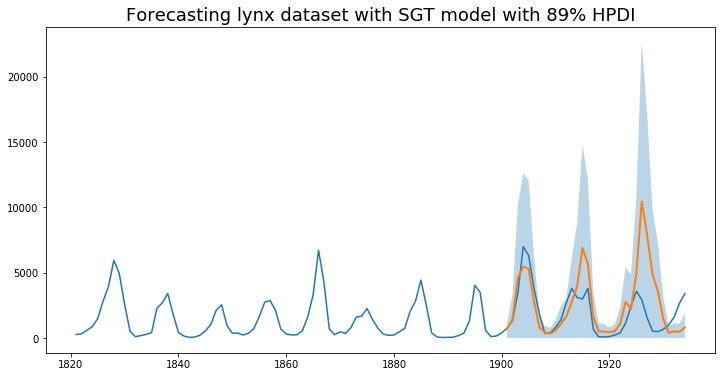

In [14]:
rngs = random.split(random.PRNGKey(3), samples["nu"].shape[0])
forecast_marginal = vmap(lambda rng, asample: forecast(
    rng, sgt_forecast, asample, future=34, y=y, seasonality=38))(rngs, samples)
plot_forecast_marginal(forecast_marginal)

In [15]:
target = data[80:]
prediction = np.mean(np.stack(list(forecast_marginal.values()), axis=1), axis=0)
sMAPE = np.mean(np.abs(prediction - target) / (prediction + target)) * 200
msqrt = np.sqrt(np.mean(prediction - target) ** 2)
print("sMAPE: {:.2f}, mse: {:.2f}".format(sMAPE, msqrt))

sMAPE: 70.10, mse: 651.33
